# Create a Random Number Generating Quantum Circuit
Goals: Create a (8bit) RNG and denoise + implement error mitigation techniques. Implement 1 use case (encryption)
Note: It would be hard to simulate 32 qubits on a classical computer (2^32 states)  
Possible use case: Encryption/Decryption


#### Description
This basic QRNG leverages quantum superposition and measurement to generate truly random 8-bit integers. The circuit initializes 8 qubits in the ground state |0>, then applies a Hadamard gate (H) to each qubit. Each Hadamard transforms its qubit into an equal superposition of |0> and then |1> yielding  
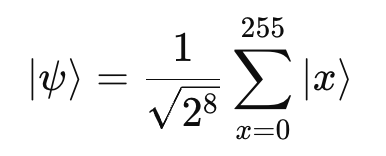  

This creates a uniform probability distribution across all 2^8=256 possible bitstrings. Upon measurement in the computational (Z) basis, the superposition collapses to one of these 256 outcomes with equal probability (1/2^8). The measurement results are stored in 8 classical registers, producing an 8-bit binary string, which is then converted to an integer in the range 0–255.  
Each execution of the circuit therefore produces a truly random 8-bit number, derived from the fundamental indeterminacy of quantum measurement.


## Setup

In [13]:
# %pip install 'qiskit[visualization]' qiskit-ibm-runtime qiskit-aer qiskit_qasm3_import

import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Pauli, SparsePauliOp, Statevector
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler, EstimatorV2 as Estimator, QiskitRuntimeService, Options
import matplotlib.pyplot as plt

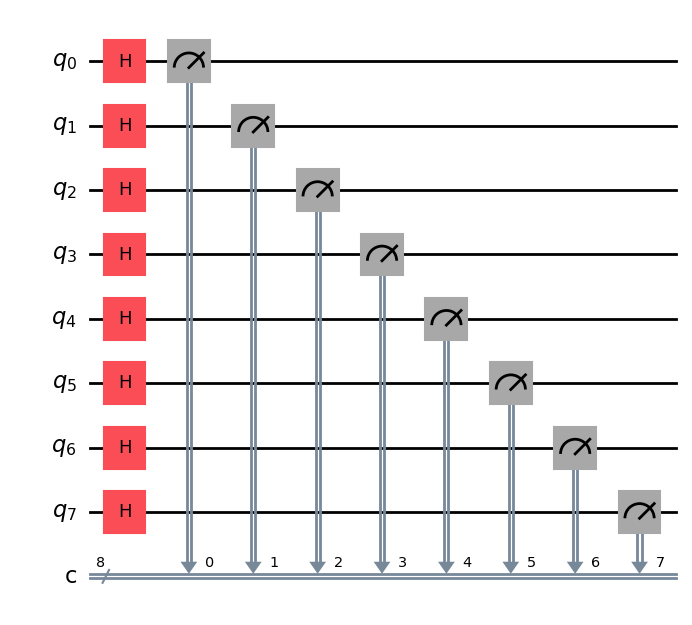

In [14]:
# Initialize quantum circuit with 8 qubits and 8 classical registers
num_qubits = 8
num_classical_registers = num_qubits
qc = QuantumCircuit(num_qubits, num_classical_registers)

# Apply Hadamard gate to all qubits to create superposition and equal probabilities (1/(2^n) per state)
for i in range(num_qubits):
    qc.h(i)

# Measure all qubits
qc.measure(range(num_qubits), range(num_classical_registers))
qc.draw('mpl')

In [15]:
# Simulate results with AerSimulator
simulator = AerSimulator()
shots = 100000
result =  simulator.run(qc, shots=shots).result()
counts = result.get_counts()


In [ ]:
def plot_exp_probs(counts):
    probs_ints_q0_msb = {int(b[::-1], 2): c / shots for b, c in counts.items()}

    # --- Expected uniform probability and 1σ error bar (sampling noise) ---
    n = qc.num_qubits
    p_exp = 1.0 / (2 ** n)
    sigma = np.sqrt(p_exp * (1 - p_exp) / shots)  # binomial std
    print(f"Expected probability for each of {2**n} outcomes: {p_exp:.5f} ± {sigma:.5f}")
    
    # Plot histogram of results
    xs = list(probs_ints_q0_msb.keys())
    ps = [probs_ints_q0_msb[x] for x in xs]
    plt.figure(figsize=(12, 6))
    plt.bar(xs, ps)
    plt.xlabel("Measured value (integer)")
    plt.ylabel("Probability")
    plt.title("QRNG outcome distribution")
    plt.ylim(0, .006)
    plt.show()

    return probs_ints_q0_msb

Expected probability for each of 256 outcomes: 0.00391 ± 0.00020


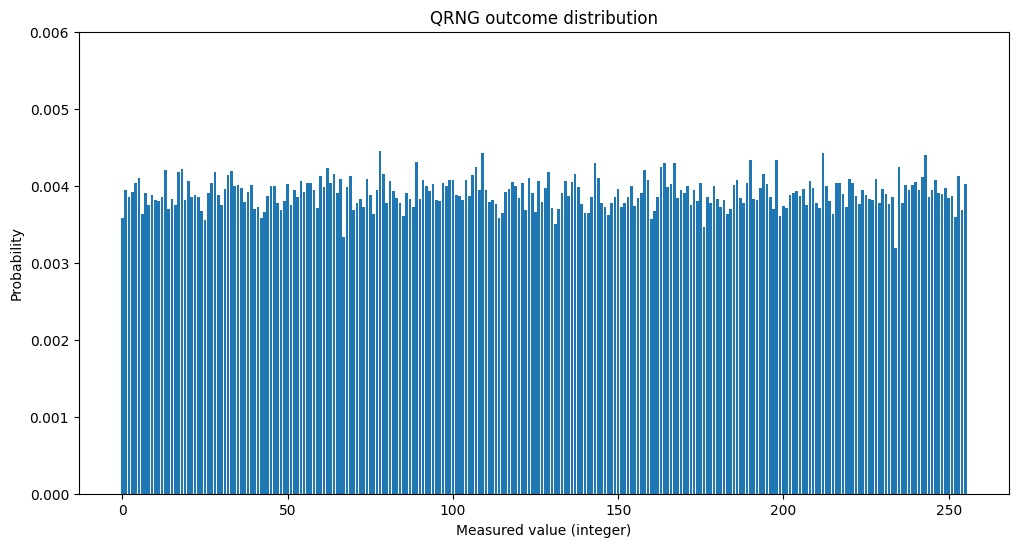

Average probability: 0.00391


In [17]:
probs = plot_exp_probs(counts)
avg_prob = sum(probs.values()) / len(probs)
print(f"Average probability: {avg_prob:.5f}")

### Error Mitigation (summary and some analysis)
#### What are the main causes of some values being returned more than others?  
Probably due to instrinsic noise of quantum systems  
#### How to mitgate this?  
Best strategies might include fixing measurement bias (when 0's are read as 1's and vice versa), optimizing the circuit, using dynamic decoupling to supress idle-time decoherence.
  
Note: Additional noise in the circuit would still keep in random but it would be biased based on the noise interference. If we want to make a fair RN, then we would need to mitigate noise and error.

In [18]:
from qiskit_ibm_runtime.fake_provider import FakeHanoiV2
# Similulate with circuit with noise using FakeVigoV2
fake_backend = FakeHanoiV2()
noisy_simulator = AerSimulator.from_backend(fake_backend)
qc_transpiled = transpile(qc, noisy_simulator)
qc_isa = transpile(qc, fake_backend, optimization_level=3)
original_depth = qc.depth()
print(f"Original circuit depth: {original_depth}")
qc_transpiled.draw()
isa_depth = qc_isa.depth()
print(f"ISA transpiled circuit depth: {isa_depth}")
qc_isa.draw()


Original circuit depth: 2
ISA transpiled circuit depth: 4


global phase: 0
          ┌─────────┐┌────┐┌─────────┐            ┌─┐         
 q_4 -> 0 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├────────────┤M├─────────
          ├─────────┤├────┤├─────────┤            └╥┘┌─┐      
 q_5 -> 2 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─────────────╫─┤M├──────
          ├─────────┤├────┤├─────────┤         ┌─┐ ║ └╥┘      
 q_3 -> 5 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─────────┤M├─╫──╫───────
          ├─────────┤├────┤├─────────┤         └╥┘ ║  ║ ┌─┐   
q_6 -> 14 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├──────────╫──╫──╫─┤M├───
          ├─────────┤├────┤├─────────┤   ┌─┐    ║  ║  ║ └╥┘   
q_1 -> 19 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├───┤M├────╫──╫──╫──╫────
          ├─────────┤├────┤├─────────┤┌─┐└╥┘    ║  ║  ║  ║    
q_0 -> 20 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤M├─╫─────╫──╫──╫──╫────
          ├─────────┤├────┤├─────────┤└╥┘ ║ ┌─┐ ║  ║  ║  ║    
q_2 -> 24 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─╫──╫─┤M├─╫──╫──╫──╫────
          ├─────────┤├────┤├─────────┤ ║  ║ └╥┘ ║  ║  ║  ║ ┌─┐
q_7 -> 26 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─╫──╫──╫──╫──╫──╫──╫─┤M├
          └─────────┘└────┘└─────────┘ ║  ║  ║  ║  ║  ║  ║ └╥┘
     c: 8/═════════════════════════════╩══╩══╩══╩══╩══╩══╩══╩═
                                       0  1  2  3  4  5  6  7

Notice how the transpiled circuit has no H gates. This is because the backend we are using has no 'hardware' supporting H gates.

Graph 1: Noisy Circuit Results
Expected probability for each of 256 outcomes: 0.00391 ± 0.00020


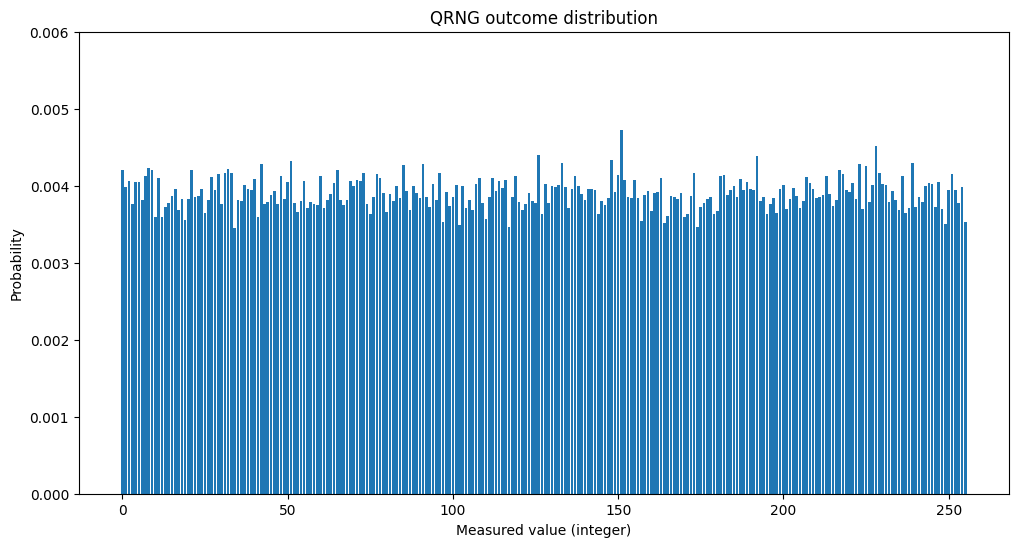

Average probability (noisy): 0.0039062499999999987
Graph 2: Optimized with Transpile and Optimization Level Noisy Circuit Results
Expected probability for each of 256 outcomes: 0.00391 ± 0.00020


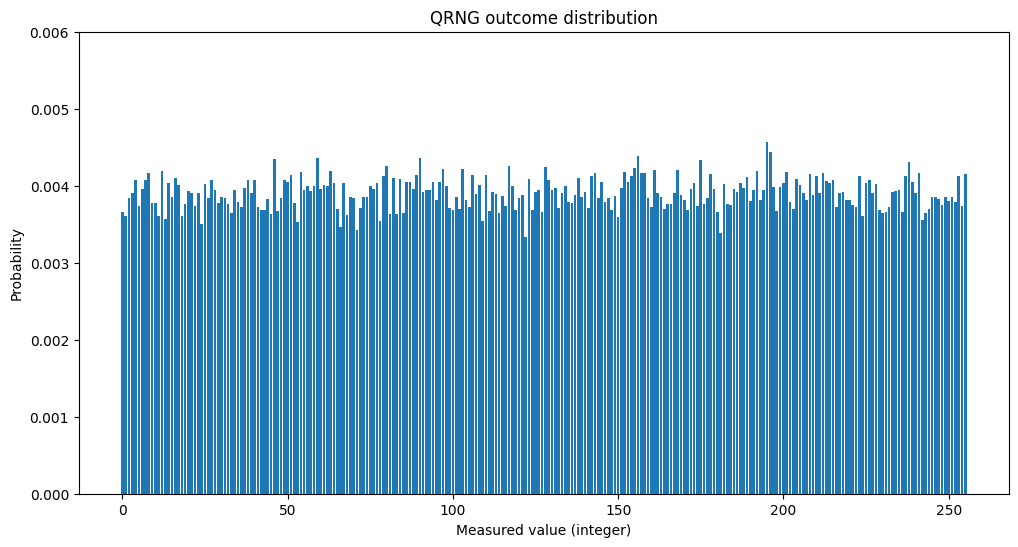

Average probability (optimized): 0.003906249999999999


In [19]:
# Check results with noise, optimize it, check again
print("Graph 1: Noisy Circuit Results")
result_noisy =  noisy_simulator.run(qc_transpiled, shots=shots).result()
counts_noisy = result_noisy.get_counts()
probs_noisy = plot_exp_probs(counts_noisy)
avg_prob_noisy = sum(probs_noisy.values()) / len(probs_noisy)
print(f"Average probability (noisy): {avg_prob_noisy}")

# Check optimized results
print("Graph 2: Optimized with Transpile and Optimization Level Noisy Circuit Results")
result_opt =  noisy_simulator.run(qc_isa, shots=shots).result()
counts_opt = result_opt.get_counts()
probs_opt = plot_exp_probs(counts_opt)
avg_prob_opt = sum(probs_opt.values()) / len(probs_opt)
print(f"Average probability (optimized): {avg_prob_opt}")


#### Noise Analysis


In [20]:
from qiskit_experiments.library import StateTomography

# Note we have to use a circuit with 4 qubits or less for state tomography due to exponential scaling (still too much ram for my instance to handle)
# qc_small = QuantumCircuit(4,4)
# for i in range(4):
#     qc_small.h(i)
# qc_small.measure(range(4), range(4))
# qc_small.draw('mpl')

# qc_transpiled_small = transpile(qc_small, noisy_simulator)

# state_tom = StateTomography(qc_transpiled_small)
# tomo_exp = state_tom.run(noisy_simulator, seed_similation=100).block_for_results()
# display(tomo_exp.analysis_results(dataframe=True))


Note: since randomness is preserved through the noise (although mykaing it slightly biased), it is still random, which is okay for our use case. Ideally we would run further noise analysis in order to reduce noise and mitigate any errors we may find.

## Hybrid Encryption Algorithm (Possible Use Case)

In [21]:
from cryptography.hazmat.primitives.ciphers.aead import ChaCha20Poly1305
from cryptography.hazmat.primitives.kdf.hkdf import HKDF
from cryptography.hazmat.primitives import hashes
import os

In [22]:
def qrng_byte() -> int:
    """Return one quantum-random integer in 0..255."""
    # We will use the optimized circuit to simulate QRNG byte generation (since it is optimized and randomness is preserved though there is noise)
    result = noisy_simulator.run(qc_isa, shots=1).result()
    counts = result.get_counts()
    bitstring = list(counts.keys())[0]  
    return int(bitstring[::-1], 2)  

def qrng_bytes(n: int) -> bytes:
    """Collect n bytes from the 8-bit QRNG."""
    return bytes(qrng_byte() for _ in range(n))

# Von Neumann extractor for bias removal over a bitstring
def von_neumann(bits: str) -> str:
    out = []
    for i in range(0, len(bits) - 1, 2):
        a, b = bits[i], bits[i+1]
        if a != b:
            out.append(a)         # 01 -> 0, 10 -> 1
    return ''.join(out)

# Helper: pack a '0'/'1' string into bytes
def bits_to_bytes(bitstr: str) -> bytes:
    if len(bitstr) % 8 != 0:
        bitstr += '0' * (8 - (len(bitstr) % 8))
    return int(bitstr, 2).to_bytes(len(bitstr)//8, 'big')

# === 2) Derive a 256-bit key from quantum entropy ===
def derive_key_from_qrng(min_bytes: int = 32, use_von_neumann: bool = False) -> bytes:
    """
    Gather >=32 QRNG bytes, optionally run von Neumann debiasing at bit level,
    then HKDF(SHA-256) -> 32-byte key.
    """
    raw = qrng_bytes(min_bytes if not use_von_neumann else min_bytes*2)

    if use_von_neumann:
        # Convert to bits, debias, then repack
        bits = ''.join(f'{b:08b}' for b in raw)
        debiased_bits = von_neumann(bits)
        if len(debiased_bits) < 256:  # ensure enough entropy after discards
            while len(debiased_bits) < 256:
                more = qrng_bytes(16)
                bits += ''.join(f'{b:08b}' for b in more)
                debiased_bits = von_neumann(bits)
        seed = bits_to_bytes(debiased_bits[:256])
    else:
        seed = raw  # rely on HKDF as a strong extractor for practical use

    hkdf = HKDF(algorithm=hashes.SHA256(), length=32, salt=None, info=b"QRNG-KEY")
    key = hkdf.derive(seed)  # 32 bytes (256-bit)
    return key

# === 3) AEAD encryption/decryption with ChaCha20-Poly1305 ===
def encrypt_qrng_aead(plaintext: bytes, aad: bytes = b"") -> tuple[bytes, bytes, bytes]:
    """
    Returns (nonce, ciphertext, key). In real systems, STORE key securely and
    send (nonce, ciphertext) to the receiver. Nonce must be unique per message.
    """
    key = derive_key_from_qrng(min_bytes=32, use_von_neumann=True)
    nonce = os.urandom(12)  # 96-bit nonce; must be unique per key
    aead = ChaCha20Poly1305(key)
    ct = aead.encrypt(nonce, plaintext, aad)  # ciphertext || 16-byte tag
    return nonce, ct, key

def decrypt_qrng_aead(nonce: bytes, ciphertext: bytes, key: bytes, aad: bytes = b"") -> bytes:
    aead = ChaCha20Poly1305(key)
    return aead.decrypt(nonce, ciphertext, aad)

In [23]:
# Test Run
msg = b"hello world"
nonce, ct, key = encrypt_qrng_aead(msg, aad=b"demo")
print("Ciphertext:", ct)
pt = decrypt_qrng_aead(nonce, ct, key, aad=b"demo")

assert pt == msg
print("Decrypted OK, length:", len(msg))

Ciphertext: b'\xf2|\x112\x85*\x133\xffy\xc8l\xd6\x86\x8d\r\xa4D\x19n\xaaU(\x96\xe8ex'
Decrypted OK, length: 11


Normally, software seeds come from pseudorandom generators (e.g., /dev/urandom, system noise, CPU jitter).
They are computationally unpredictable, but not fundamentally unpredictable. Their entropy source might, in theory, be modeled or compromised. Generates entropy from quantum measurement, which is irreducibly random (not due to ignorance, but fundamental indeterminacy). So seed generation should truly be random. Even if an attacker somehow knew your full system state, they could not predict your key, because its bits were derived from genuine quantum randomness.
  
Constraints included only using 8 modeled qbits. My classical machine could not handle greater than that. Ideally, the seed would be directly be generated by one shot of the quantum circuit instead of concatenating results. This is a step into how quantum machines can help improve classical encryption.